# Exploratory Data Analysis
TEAM 81: AMVA

In [1]:
import os
from time import time, strftime, gmtime

import numpy as np
import pandas as pd
from pykml.parser import parse

# Math
from geopy.distance import distance

# NLP
import regex as re

# Visualizaction
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import folium

## Setup

In [2]:
PATH = r'C:\Users\USER\OneDrive\DS4A\Project'
os.chdir(PATH)

# Parameters
stage = 'EDA'
save_figures = True
PATH_PLOT = rf'Plots\{stage}'
if not os.path.exists(rf'{PATH}\{PATH_PLOT}'):
    os.makedirs(PATH_PLOT)
    print(rf'{PATH}\{PATH_PLOT} has been created')

startTIME = time()

In [3]:
sns.set()
plt.rcParams['figure.figsize'] = (15, 5)
plt.rcParams['axes.titlepad'] = 16

## Load Data 

In [4]:
os.listdir(r'Data')

['CSV_INICIAL',
 'Detalle recorridos 22 sept.csv',
 'Diccionario de datos.docx',
 'Empresas de transporte TPC.csv',
 'RUTAS',
 'Vehiculos TPC por empresa.csv']

### BUS

In [5]:
%%time

dtypes = {
    'SECUENCIARECORRIDO': 'uint32',
    'CONSECUTIVOREGISTRO': 'uint32',
    'RECORRIDOFINALIZADO': 'category',
    'IDVEHICULO': 'uint16',
    'IDEMPRESA': 'uint8',
    'CODIGORUTA': 'uint32',
    'LATITUD': 'float64',
    'LONGITUD': 'float64',
    'VELOCIDAD': 'uint16',
    'ESTADOPUERTAS': 'category',
    'SUBENDELANTERA': 'uint8',
    'SUBENTRASERA': 'uint8',
    'BAJANDELANTERA': 'uint8',
    'BAJANTRASERA': 'uint8',
    'ACUMULADOPASAJEROS': 'uint16'
}

BUS = pd.read_csv(
    r'Data\Detalle recorridos 22 sept.csv',
    parse_dates=['FECHAREGISTRO'],
    infer_datetime_format=True,
    dtype=dtypes
)

BUS['MARGENDESVIACION'] =\
BUS['MARGENDESVIACION'].str.replace(',', '.').astype('float16')

Wall time: 37.6 s


### RUTAS

In [6]:
%%time

dtypes = {
    'LATITUD': 'float64',
    'LONGITUD': 'float64',
    'CODIGORUTA': 'uint32'
}

def KML_dataframe(filename):
    file_location = rf'Data\RUTAS\{filename}'
    with open(file_location) as f:
        KML = parse(f).getroot()
        
        try:
            latlong = str(KML.Document.Placemark.MultiGeometry.LineString.coordinates).strip()
        except:
            try:
                latlong = str(KML.Document.Placemark.LineString.coordinates).strip()
            except:
                return pd.DataFrame(
                        [[999, 999, str(filename.split('.')[0])]],
                        columns=['LONGITUD', 'LATITUD', 'CODIGORUTA'],
                       ).astype(dtypes)
            
        df = pd.DataFrame(
            [row.split(',')[:2] + [filename.split('.')[0]] for row in latlong.split(' ')],
            columns=['LONGITUD', 'LATITUD', 'CODIGORUTA'],
        ).astype(dtypes)
        
        return df

    
RUTAS = pd.concat(
    map(
        lambda filename: KML_dataframe(filename),
        [file for file in  os.listdir(r'Data\RUTAS')]
    )
).reset_index(drop=True)[['LATITUD', 'LONGITUD', 'CODIGORUTA']]

RUTAS[RUTAS['LATITUD'] == 999]

Wall time: 2.32 s


,LATITUD,LONGITUD,CODIGORUTA
85009,999.0,999.0,52030


## Memory Usage

### BUS

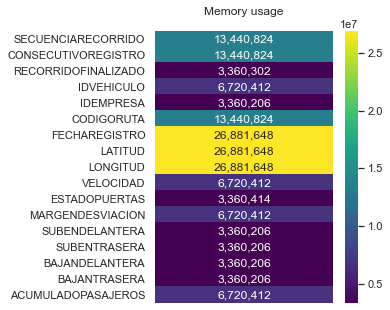

In [7]:
plt.figure(figsize=(4, 5))
sns.heatmap(
    BUS.memory_usage(index=False).to_frame(),
    cmap='viridis',
    annot=True,
    fmt=',d',
    xticklabels=False
)
plt.title('Memory usage');

if save_figures:
    plt.savefig(rf'{PATH_PLOT}\MemoryUsage_BUS', 
                dpi=300,
                bbox_inches='tight')

### RUTAS

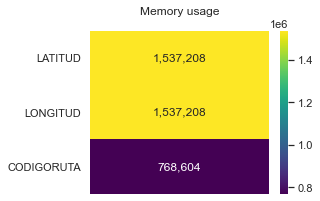

In [8]:
plt.figure(figsize=(4, 3))
sns.heatmap(
    RUTAS.memory_usage(index=False).to_frame(),
    cmap='viridis',
    annot=True,
    fmt=',d',
    xticklabels=False
)
plt.title('Memory usage');

if save_figures:
    plt.savefig(rf'{PATH_PLOT}\MemoryUsage_BUS', 
                dpi=300,
                bbox_inches='tight')

## NaN and Unique Values 

### BUS 

In [9]:
BUS.info(null_counts=True, memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3360206 entries, 0 to 3360205
Data columns (total 17 columns):
 #   Column               Non-Null Count    Dtype         
---  ------               --------------    -----         
 0   SECUENCIARECORRIDO   3360206 non-null  uint32        
 1   CONSECUTIVOREGISTRO  3360206 non-null  uint32        
 2   RECORRIDOFINALIZADO  3360206 non-null  category      
 3   IDVEHICULO           3360206 non-null  uint16        
 4   IDEMPRESA            3360206 non-null  uint8         
 5   CODIGORUTA           3360206 non-null  uint32        
 6   FECHAREGISTRO        3360206 non-null  datetime64[ns]
 7   LATITUD              3360206 non-null  float64       
 8   LONGITUD             3360206 non-null  float64       
 9   VELOCIDAD            3360206 non-null  uint16        
 10  ESTADOPUERTAS        3360206 non-null  category      
 11  MARGENDESVIACION     3360206 non-null  float16       
 12  SUBENDELANTERA       3360206 non-null  uint8         
 1

In [10]:
BUS.apply(lambda col: col.nunique())

SECUENCIARECORRIDO      15319
CONSECUTIVOREGISTRO      4038
RECORRIDOFINALIZADO         2
IDVEHICULO               2834
IDEMPRESA                  41
CODIGORUTA                302
FECHAREGISTRO          107329
LATITUD                273781
LONGITUD               138792
VELOCIDAD                 177
ESTADOPUERTAS               6
MARGENDESVIACION          904
SUBENDELANTERA             97
SUBENTRASERA               61
BAJANDELANTERA             91
BAJANTRASERA               97
ACUMULADOPASAJEROS       1210
dtype: int64

### RUTAS

In [11]:
RUTAS.info(null_counts=True, memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192151 entries, 0 to 192150
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   LATITUD     192151 non-null  float64
 1   LONGITUD    192151 non-null  float64
 2   CODIGORUTA  192151 non-null  uint32 
dtypes: float64(2), uint32(1)
memory usage: 3.7 MB


In [12]:
RUTAS.apply(lambda col: col.nunique())

LATITUD       94091
LONGITUD      92727
CODIGORUTA      270
dtype: int64

## Basic Statistics 

### BUS

#### Numerical

In [13]:
numerical_columns = BUS.select_dtypes(exclude=['object', 'category', 'datetime'])\
                       .drop(columns=['SECUENCIARECORRIDO', 
                                      'CONSECUTIVOREGISTRO', 
                                      'IDVEHICULO', 
                                      'IDEMPRESA', 
                                      'CODIGORUTA']).columns

In [14]:
BUS[numerical_columns].describe().applymap(lambda e: f'{e:.2f}')

,LATITUD,LONGITUD,VELOCIDAD,MARGENDESVIACION,SUBENDELANTERA,SUBENTRASERA,BAJANDELANTERA,BAJANTRASERA,ACUMULADOPASAJEROS
count,3360206.00,3360206.00,3360206.00,3360206.00,3360206.00,3360206.00,3360206.00,3360206.00,3360206.00
mean,6.24,-75.58,11.82,nan,0.13,0.01,0.04,0.10,9387.52
std,0.07,0.40,16.30,0.00,1.26,0.54,0.81,0.88,22945.64
min,0.00,-75.71,0.00,1.00,0.00,0.00,0.00,0.00,0.00
25%,6.20,-75.59,0.00,1.20,0.00,0.00,0.00,0.00,2.00
50%,6.25,-75.57,2.00,1.50,0.00,0.00,0.00,0.00,7.00
75%,6.28,-75.57,20.00,1.90,0.00,0.00,0.00,0.00,18.00
max,6.45,0.00,773.00,100.00,99.00,96.00,99.00,97.00,65535.00


In [15]:
BUS['SUBEN'] = BUS['SUBENTRASERA'] + BUS['SUBENDELANTERA']
BUS.groupby('CODIGORUTA')['SUBEN'].sum().sort_values(ascending=False)

CODIGORUTA
7202       19347.0
9108       18418.0
9105       11632.0
9104       11424.0
7201       10915.0
            ...   
111415         0.0
111405         0.0
111395         0.0
4001000        0.0
111115         0.0
Name: SUBEN, Length: 302, dtype: float64

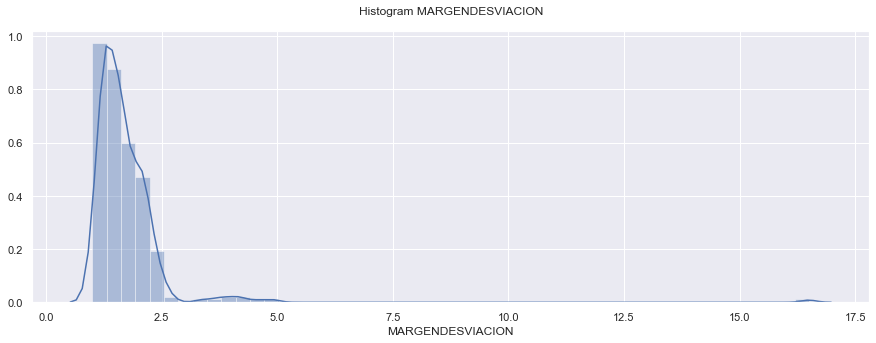

In [16]:
sns.distplot(BUS.groupby('CODIGORUTA')['MARGENDESVIACION'].mean());
plt.title('Histogram MARGENDESVIACION')

if save_figures:
    plt.savefig(rf'{PATH_PLOT}\MemoryUsage_BUS', 
                dpi=300,
                bbox_inches='tight')

#### Categorical 

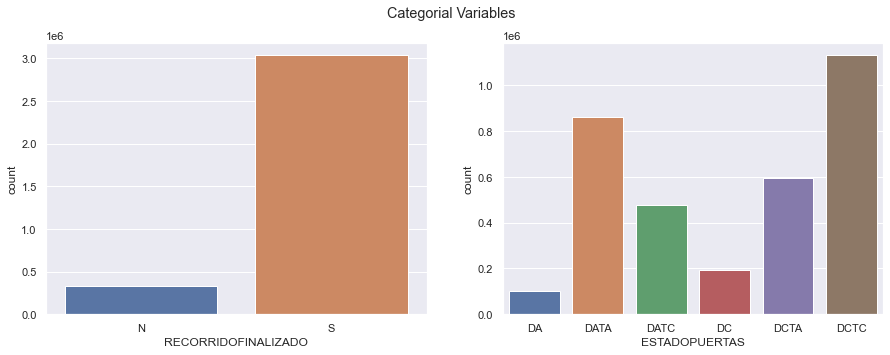

In [17]:
categorical_col = BUS.select_dtypes('category').columns
fig, axs = plt.subplots(1, len(categorical_col))
for i, col in enumerate(categorical_col):
    sns.countplot(BUS[col], ax=axs[i])
fig.suptitle('Categorial Variables');

if save_figures:
    plt.savefig(rf'{PATH_PLOT}\MemoryUsage_BUS', 
                dpi=300,
                bbox_inches='tight')

In [18]:
BUS.groupby('SECUENCIARECORRIDO')['RECORRIDOFINALIZADO'].agg(lambda row: len(set(row))).unique()

array([1], dtype=int64)

#### Datetime

FECHAREGISTRO
	days:  [20, 21, 22, 23]
	months:  [9]
	years:  [2020]


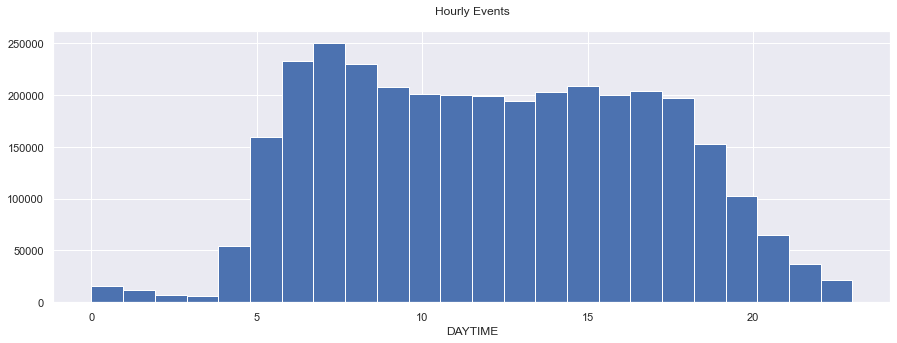

In [19]:
for col in BUS.select_dtypes('datetime64'):
    print(col)
    for partDT in ['day', 'month', 'year']:
        print(
            f'\t{partDT}s: ',
            eval(
                f"sorted(BUS[col].dt.{partDT}.unique())"
            )
        )
    
    plt.hist(BUS[col].dt.hour, bins=24)
    plt.title('Hourly Events')
    plt.xlabel('DAYTIME')
    
    if save_figures:
        plt.savefig(rf'{PATH_PLOT}\Dist_HourlyEvents_{col}', dpi=300)
        
    plt.show()

### RUTAS

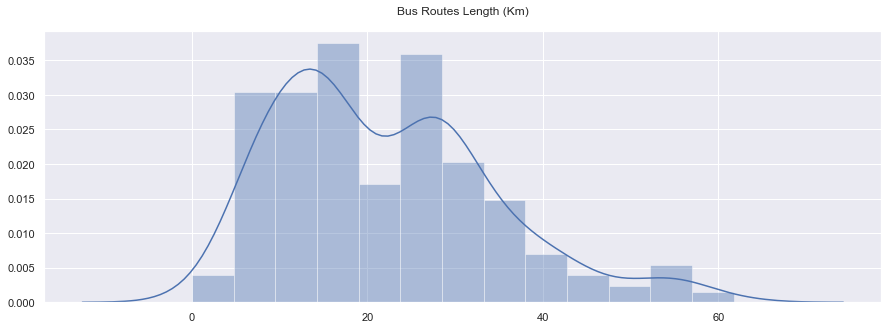

In [20]:
RUTAS_km = RUTAS.groupby('CODIGORUTA').agg(list)
RUTAS_km = RUTAS_km.apply(lambda c: list(zip(c['LATITUD'], c['LONGITUD'])), axis=1)
RUTAS_km = RUTAS_km.apply(lambda row: sum([distance(x, x_1).km for x, x_1 in zip(row, row[1:])]))\
                   .to_frame()

sns.distplot(RUTAS_km)
plt.title('Bus Routes Length (Km)');

if save_figures:
    plt.savefig(rf'{PATH_PLOT}\MemoryUsage_BUS', 
                dpi=300,
                bbox_inches='tight')

## Potential Outliers

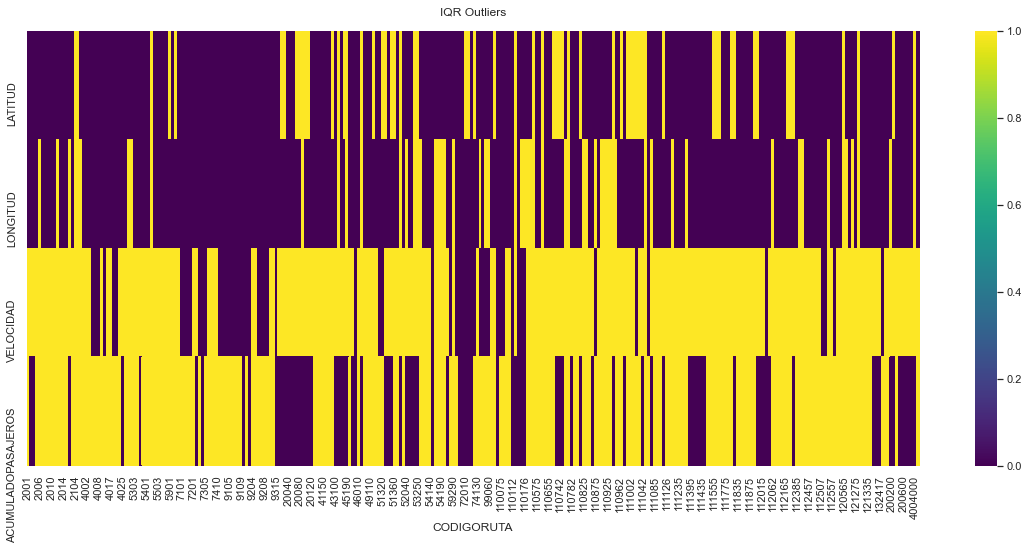

In [21]:
def outlier_IQR(_list):
    Q1, Q3 = np.percentile(_list, [25, 75])
    idx = [
        (e < Q1 - 1.5*(Q3 - Q1)) or (e > Q3 + 1.5*(Q3 - Q1))
        for e in _list
    ]

    return any(idx)


plt.figure(figsize=(20, 8))
sns.heatmap(
    BUS.groupby('CODIGORUTA')[['LATITUD',
                               'LONGITUD',
                               'VELOCIDAD',
                               'ACUMULADOPASAJEROS']]\
              .agg(lambda e: outlier_IQR(list(e))).T,
    vmin=0,
    vmax=1,
    cmap='viridis'
)
plt.title('IQR Outliers');

if save_figures:
    plt.savefig(rf'{PATH_PLOT}\MemoryUsage_BUS', 
                dpi=300,
                bbox_inches='tight')

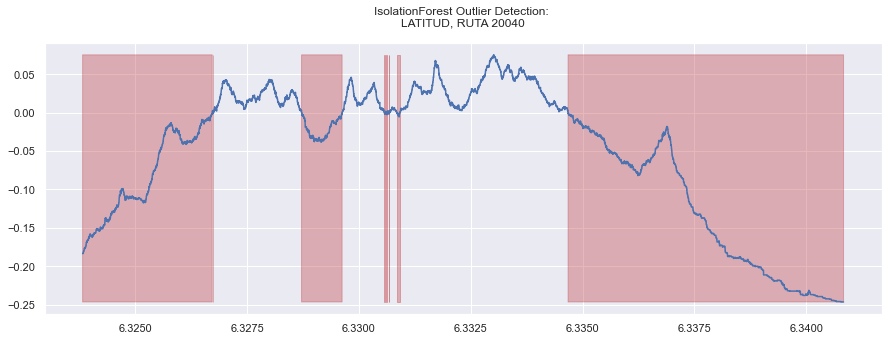

In [22]:
# Outlier experiment
from sklearn.ensemble import IsolationForest
data = BUS[BUS['CODIGORUTA'] == 20040
          ]['LATITUD'].values.reshape(-1, 1)
clf = IsolationForest(random_state=914)
clf.fit(data)

xx = np.linspace(data.min(), data.max(), len(data)).reshape(-1,1)
anomaly_score = clf.decision_function(xx)
outlier = clf.predict(xx)

plt.plot(xx, anomaly_score, label='anomaly score')
plt.fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score), 
                 where=outlier==-1, color='r', 
                 alpha=.4, label='outlier region')
plt.title('IsolationForest Outlier Detection: \nLATITUD, RUTA 20040');

if save_figures:
    plt.savefig(rf'{PATH_PLOT}\IsolationForest_ex', dpi=300)

In [23]:
# # selenium experiment to save folium as image
# from selenium import webdriver
# from time import sleep, time
# from selenium.webdriver.common.keys import Keys

# driver = webdriver.Chrome(executable_path=r'C:\Users\USER\Downloads\chromedriver.exe')
# driver.get('http://localhost:8888/notebooks/OneDrive/DS4A/Project/ExploratoryAnalysis.ipynb')
# elem = driver.find_element_by_id('password_input')
# # !jupyter notebook list # Get Token
# elem.send_keys('ENTER YOUR KEYS')
# elem.send_keys(Keys.ENTER)
# elem = driver.find_element_by_class_name('leaflet-control-zoom-in')
# elem.click()
# sleep(3)
# driver.save_screenshot('test_screen.png')

In [24]:
def display_map(CODIGORUTA):
    RUTA = RUTAS[RUTAS['CODIGORUTA'] == CODIGORUTA].iloc[:, :2]

    AMVA = folium.Map(location=RUTA.mean().values)

    tooltip = CODIGORUTA

    df_ruta = BUS[BUS['CODIGORUTA'] == CODIGORUTA]

    # Take sample
    try:
        idx = df_ruta.sample(100).index
    except:
        idx = df_ruta.index
     
    # BUS data
    for i in idx:
        folium.Marker(
            (df_ruta['LATITUD'][i], df_ruta['LONGITUD'][i]),
            popup='<i>index</i>', 
            tooltip=tooltip
        ).add_to(AMVA)

    # RUTAS data
    folium.PolyLine(
        list(zip(RUTA.values, RUTA.values[1:])),
        color="red", weight=8, opacity=1
    ).add_to(AMVA)
    
    # Auto Zoom Map
    sw = df_ruta[['LATITUD', 'LONGITUD']].min().values.tolist()
    ne = df_ruta[['LATITUD', 'LONGITUD']].max().values.tolist()
    AMVA.fit_bounds([sw, ne]) 
    
    if save_figures:
        AMVA.save(rf'{PATH_PLOT}\{CODIGORUTA}.html')
        
    return AMVA

In [25]:
rutas_wKML = list(set(BUS['CODIGORUTA']).intersection(set(RUTAS['CODIGORUTA'])))
for ruta in rutas_wKML[:5]:
    display(display_map(ruta))
    print()

### Execution time

In [32]:
endTIME = time()
print('Execution time: ', strftime("%Hh%Mm%Ss", gmtime(endTIME - startTIME)))

Execution time:  00h03m07s
